<a href="https://colab.research.google.com/github/JuniorHZ19/CNN-PARA-DETECION-DE-OBJETOS/blob/main/R-CNN%20v2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

!pip uninstall opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/cv2/*
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.11

In [3]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset

import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset

class PascalVOCDataset(Dataset):

    def __init__(self, images_dir, annotations_dir,ref_labels, transform=None):
        self.ref_labels=ref_labels #referencia posiciones de cada clase seguira el mismo orden +1
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

        # Lista de todas las imágenes y sus anotaciones
        self.image_filenames = [
            f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))
        ]

    def __len__(self):
        """Devuelve el tamaño del dataset."""
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Devuelve una imagen y su correspondiente anotación.

        Parámetros:
        - idx: Índice de la imagen.

        Retorna:
        - image: Tensor de la imagen.
        - target: Diccionario con bounding boxes y etiquetas.
        """
        # Cargar la imagen
        image_filename = self.image_filenames[idx]

        image_path = os.path.join(self.images_dir, image_filename)

        image=cv2.imread(image_path)

        # Cargar la anotación correspondiente
        annotation_path = os.path.join(
            self.annotations_dir, os.path.splitext(image_filename)[0] + ".xml"
        )

        anotacion = self._parse_annotation(annotation_path)

        image=np.array(image)

        return image, anotacion

    def _parse_annotation(self, annotation_path):

        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):

            label = obj.find("name").text

            label= (self.ref_labels.index(label))+1
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

            anotacion = {
            "boxes":boxes,
            "labels": labels
              }

        return anotacion

2000


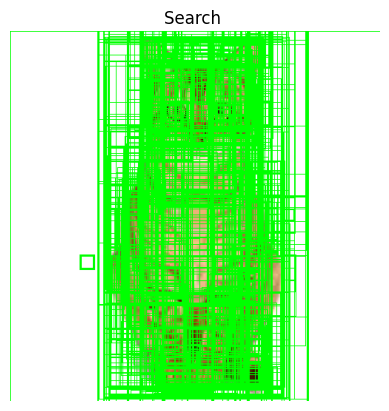

In [5]:
#Creando funcion para generacion de regioness propuestas:

import cv2
import matplotlib.pyplot as plt

# Cargar la imagen
image = cv2.imread('/content/imagenes/69.jpg')
height, width = image.shape[:2]
aspect_ratio = height / width
new_height = int(500 * aspect_ratio)
resized_image = cv2.resize(image, (500, new_height)) #En el paper recomienda que todas las imagenes tengan el mismo ancho para tener mejores regiones propuestas

def get_Region_Proposals(img,max_regiones=2000,fast_mode=False):


# Crear un objeto de Selective Search

  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

  image_bgr = cv2.cvtColor(img , cv2.COLOR_RGB2BGR)

# Configurar la imagen para Selective Search
  ss.setBaseImage(image_bgr)


# Modo rápido o calidad

  if (fast_mode==True):

    ss.switchToSelectiveSearchFast()

  else :
    ss.switchToSelectiveSearchQuality()  # Más preciso pero más lentoiso

# Ejecutar Selective Search para obtener las regiones propuestas
  rects = ss.process()   #RECTAS CON FORMATO  x,y,w,h

  rects= rects[:max_regiones]

  rectas=[]

  for x, y, w, h in rects:

     rectas.append([x, y, x + w, y + h]) #formato xmin,ymin ,xmax,ymax

  return rectas


rectas_propuestas=get_Region_Proposals(resized_image)
print(len(rectas_propuestas))
image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

# Dibujar las regiones propuestas en la imagen
for (x, y, xmax, ymax) in rectas_propuestas:  # Limitar a las primeras 100 regiones para visualizar
    cv2.rectangle(image_rgb, (x, y), (xmax, ymax), (0, 255, 0), 1)
# Mostrar la imagen con Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

(224, 224, 3)


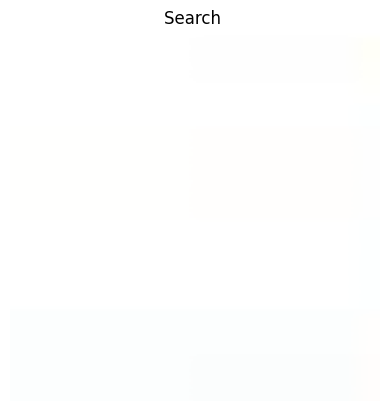

In [6]:
#Funcion redimension dee regiones para entrada al cnn:

def extract_region(image,rect,size=(224,224)):
  x=rect[0]
  y=rect[1]
  xmax=rect[2]
  ymax=rect[3]

  if x < 0 or y < 0 or xmax > image.shape[1] or ymax > image.shape[0]:
        raise ValueError("La región extraída excede los límites de la imagen.")
        print(rect)

  region=image[y:ymax, x:xmax] #crop imagen segun recta


  if region.size == 0:  # Verificar si la región extraída es válida
        raise ValueError("La región extraída tiene dimensiones inválidas.")

  img_region=cv2.resize(region, size) #redimensionar para entrada a vgg16 imanges 224x224

  return img_region

img=extract_region(resized_image,rectas_propuestas[20])

print(img.shape)

plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

In [7]:
def calculate_iou_matrix(boxes_pred, boxes_gt):
    """ Calcula la matriz de IoU entre múltiples cajas predichas y múltiples cajas ground truth. """

    x1_p, y1_p, x2_p, y2_p = boxes_pred[:, 0].reshape(-1, 1), boxes_pred[:, 1].reshape(-1, 1), boxes_pred[:, 2].reshape(-1, 1), boxes_pred[:, 3].reshape(-1, 1)

    x1_gt, y1_gt, x2_gt, y2_gt = boxes_gt[:, 0], boxes_gt[:, 1], boxes_gt[:, 2], boxes_gt[:, 3]


    # Calcular intersección
    x1_inter = np.maximum(x1_p, x1_gt)
    y1_inter = np.maximum(y1_p, y1_gt)
    x2_inter = np.minimum(x2_p, x2_gt)
    y2_inter = np.minimum(y2_p, y2_gt)

    inter_width = np.maximum(0, x2_inter - x1_inter)
    inter_height = np.maximum(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height

    # Calcular áreas individuales
    area_pred = (x2_p - x1_p) * (y2_p - y1_p)
    area_gt = (x2_gt - x1_gt) * (y2_gt - y1_gt)

    # Calcular unión
    union_area = area_pred + area_gt - inter_area

    # Calcular IoU (evitando división por cero)
    iou_matrix = inter_area / np.maximum(union_area, 1e-9)

    return iou_matrix

import numpy as np

bboxes_predicho = np.array([[ 10,  10,  50,  50],
                            [ 30,  30,  70,  70],
                            [ 60,  60, 100, 100],
                            [ 20,  20,  40,  40],
                            [ 80,  80, 120, 120]])


bboxes_reales = np.array([
    [ 20,  20,  60,  60],
     [ 70,  70, 110, 110]
])

iou_matriz=calculate_iou_matrix(bboxes_predicho,bboxes_reales)


print(iou_matriz)


[[0.39130435 0.        ]
 [0.39130435 0.        ]
 [0.         0.39130435]
 [0.25       0.        ]
 [0.         0.39130435]]


In [8]:
def draw_boxes(img,rects,labels):

    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for (x, y, w, h),label in zip(rects,labels):  # Limitar a las primeras 100 regiones para visualizar
        if(label!='fondo'  and label != 0 ):
         cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #cv2.putText(image_rgb, str(label), (x, y - int(h/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # Mostrar la imagen con Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Ocultar los ejes
    plt.show()

In [9]:
import numpy as np

def select_labels_regiones(regiones_propuestas, ground_truth_boxes, ground_truth_labels, iou_threshold=0.5, max_fondos_ratio=7):
    # Calculamos la matriz de IoU
    ious = calculate_iou_matrix(regiones_propuestas, ground_truth_boxes)
    max_ious = np.max(ious, axis=1)  # Máximo IoU por fila
    max_indices = np.argmax(ious, axis=1)  # Índices de la mejor coincidencia

    # Inicializamos etiquetas (-1 para ignoradas)
    labels = np.full_like(max_ious, -1, dtype=ground_truth_labels.dtype)

    # Identificamos regiones positivas y negativas
    positives_indices = max_ious >= iou_threshold
    negatives_indices = max_ious < 0.3

    # Etiquetamos regiones positivas con sus respectivas clases
    labels[positives_indices] = ground_truth_labels[max_indices[positives_indices]]

    # Etiquetamos regiones negativas como fondo (0)
    labels[negatives_indices] = 0

    # Calculamos el número máximo de fondos permitidos
    max_fondos = np.sum(positives_indices) * max_fondos_ratio

    # Seleccionamos índices de regiones negativas hasta el límite de fondos
    fondos_indices = np.where(negatives_indices)[0][:max_fondos]

    # Asignamos los objetivos de bounding boxes
    bbox_targets = np.zeros_like(regiones_propuestas, dtype=regiones_propuestas.dtype)
    bbox_targets[positives_indices] = ground_truth_boxes[max_indices[positives_indices]]

    # Creamos el array de índices válidos concatenando positivos y fondos
    valid_indices = np.concatenate((np.where(positives_indices)[0], fondos_indices))

    # Devolvemos solo los elementos correspondientes a los índices válidos
    return bbox_targets[positives_indices], regiones_propuestas[valid_indices], labels[valid_indices]

#selecionamos el bbox real de cada bbox que se propuesto y contenga un objeto (iou>0.7) y no consideremos el fondo, esto para entrenar el modelo regresor


In [10]:
#funciones para calcular las ranfomaciones (que tanto se desplza el boudnig box propuesto del real t_x, t_y, t_w, t_h) cual entrara al regresor que calcuialra estos translacion



def calculate_translation(bbox_pred, bbox_real):
    """
    Calcula los deltas para ajustar un bbox predicho a su equivalente real.

    Args:
        bbox_pred: (xmin_pred, ymin_pred, xmax_pred, ymax_pred)
        bbox_real: (xmin_real, ymin_real, xmax_real, ymax_real)

    Returns:
        deltas: (dx, dy, dw, dh) -> Desplazamiento en x, y, ancho y alto.
    """
    x_center_pred = (bbox_pred[0] + bbox_pred[2]) / 2
    y_center_pred = (bbox_pred[1] + bbox_pred[3]) / 2
    w_pred = bbox_pred[2] - bbox_pred[0]
    h_pred = bbox_pred[3] - bbox_pred[1]

    x_center_real = (bbox_real[0] + bbox_real[2]) / 2
    y_center_real = (bbox_real[1] + bbox_real[3]) / 2
    w_real = bbox_real[2] - bbox_real[0]
    h_real = bbox_real[3] - bbox_real[1]

    dx = x_center_real - x_center_pred
    dy = y_center_real - y_center_pred
    dw = np.log(w_real / w_pred)
    dh = np.log(h_real / h_pred)

    deltas = np.array([dx, dy, dw, dh])
    return deltas




import numpy as np


def calculate_inverse_translation(deltas, bbox_pred):
    """
    Calcula los parámetros del bounding box real a partir de los deltas y el bbox predicho.

    Args:
        deltas: (dx, dy, dw, dh) -> Desplazamiento en x, y, ancho y alto.
        bbox_pred: (xmin_pred, ymin_pred, xmax_pred, ymax_pred)

    Returns:
        bbox_real: (xmin_real, ymin_real, xmax_real, ymax_real)
    """
    x_center_pred = (bbox_pred[0] + bbox_pred[2]) / 2
    y_center_pred = (bbox_pred[1] + bbox_pred[3]) / 2
    w_pred = bbox_pred[2] - bbox_pred[0]
    h_pred = bbox_pred[3] - bbox_pred[1]

    dx, dy, dw, dh = deltas

    # Deshacer la transformación de los centros
    x_center_real = x_center_pred + dx
    y_center_real = y_center_pred + dy

    # Deshacer la transformación de las dimensiones (ancho y alto)
    w_real = w_pred * np.exp(dw)
    h_real = h_pred * np.exp(dh)

    # Recalcular las esquinas del bounding box real
    xmin_real = x_center_real - w_real / 2
    ymin_real = y_center_real - h_real / 2
    xmax_real = x_center_real + w_real / 2
    ymax_real = y_center_real + h_real / 2

    bbox_real = np.array([xmin_real, ymin_real, xmax_real, ymax_real])
    return bbox_real

In [11]:
#Crear extractor de  features con VGG16:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import cv2
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models

#creacion extractor o backbone
def extract_features_from_regions(image,regiones,modelo):

    backbone = nn.Sequential(*list(modelo.children())[:-1]) #solo tomamos las capas combolcionales de la red omitinedo el clasificador de la ultima capa

    all_features = []
    # Definir las transformaciones para preprocesar las imágenes
    transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar según ImageNet
    ])

    for region in regiones:

        region_extracted=extract_region(image,region)

        # Convertir la región redimensionada a tensor
        input_tensor = transform(region_extracted).to(device)
        input_tensor = input_tensor.unsqueeze(0)  # Añadir batch dimension


        # Extraer características usando VGG16
        with torch.no_grad():
            features = modelo.features(input_tensor)  # Extraer las características
            flattened = features.view(features.size(0), -1)
        all_features.append(flattened.squeeze().cpu().numpy())  # Almacenar las características

    return np.array(all_features)



In [12]:
from torchvision import transforms
import numpy as np
from torch.utils.data import Dataset, random_split
# Directorios del dataset
images_dir = "/content/imagenes"
annotations_dir = "/content/anotaciones"

# Definir transformaciones (opcional)
transform = transforms.Compose([
    transforms.ToTensor() # Convierte la imagen a tensor

])

# Crear el dataset
dataset = PascalVOCDataset(images_dir, annotations_dir,ref_labels=['gato','perro'])

# Particionar dataset en train y test
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
test_size = len(dataset) - train_size  # El resto para prueba

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
img,target=train_dataset[5]
print(target)
print(img.shape)

{'boxes': [[168, 11, 470, 500]], 'labels': [2]}
(500, 500, 3)


In [ ]:
#ENTRENAR CLASFICADOR SVM
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import LabelBinarizer



# SVM modelo
svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)


vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()
# Número de épocas
epochs = 1

for epoch in range(epochs):
    accuraty_total = 0
    all_features=[]
    all_labels=[]

    for image, target in train_dataset:
        # Obtener regiones propuestas
        regiones_propuestas = get_Region_Proposals(image, max_regiones=2000)
        # Seleccionar regiones

        bbox_targets,regiones_selected,labels = select_labels_regiones(np.array(regiones_propuestas), np.array(target['boxes']), np.array(target['labels']),iou_threshold=0.7)
        print(labels)
        # Extraer características
        features = extract_features_from_regions(image,regiones_selected,vgg16)
        draw_boxes(image,regiones_selected,labels)

        if len(features) > 0:
         all_features.append(features)
         all_labels.append(labels)

        # Entrenar el SVM
        print(f"Features shape: {features.shape}, Labels shape: {len(labels)}")


    all_features = np.vstack(all_features)  # Apilar las características de todas las imágenes
    all_labels = np.concatenate(all_labels)

    svm.fit(all_features, all_labels)

    # Evaluar en el conjunto de prueba
    for image_test, target_test in test_dataset:
        regiones_propuestas = get_Region_Proposals(image_test, max_regiones=2000)
        real_bbox_selected_test,regiones_selected_test , labels_test = select_labels_regiones(np.array(regiones_propuestas), np.array(target_test['boxes']), np.array(target_test['labels']),iou_threshold=0.7)
        features_test = extract_features_from_regions(image_test,regiones_selected_test,vgg16)

        if(len(features_test)>1):
         y_pred = svm.predict(features_test)
         accuraty_total += accuracy_score(y_pred, labels_test)

    accuraty_total /= len(test_dataset)
    print(f"Precisión del SVM: {accuraty_total:.2f}")
    print(features.shape)


In [14]:
#ENTRENTAR REGRESOR
from sklearn.linear_model import LinearRegression
import numpy as np

# Inicializa el regresor
regressor = LinearRegression()

vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()

# Número de épocas
epochs = 1

for epoch in range(epochs):
    accuracy_total = 0
    all_features = []
    all_deltas = []


    for image, target in train_dataset:
        # Obtener regiones propuestas
        regiones_propuestas = get_Region_Proposals(image, max_regiones=2000)

        # Seleccionar las cajas para entrenamiento evitando fondos
        bbox_targets,regiones_selected,labels = select_labels_regiones(np.array(regiones_propuestas), np.array(target['boxes']), np.array(target['labels']),iou_threshold=0.7)

        indices_filtered=[indice for  indice in range (len(labels)) if (labels[indice]>0)]
        # Extraer características de las regiones seleccionadas
        features = extract_features_from_regions(image, regiones_selected[indices_filtered], vgg16)
        translations = []
        # Almacenar las características y calcular los desplazamientos

        if len(features) > 0:

         all_features.append(features)

         for region, truth_box in zip(regiones_selected[indices_filtered], bbox_targets[indices_filtered]):
            # Calcular la diferencia (desplazamiento) entre las cajas propuestas y las reales
            translations.append(calculate_translation(region, truth_box))

         all_deltas.append(translations)

    # Apilar las características de todas las imágenes
    all_features = np.vstack(all_features)  # Apilar todas las características
    all_deltas = np.concatenate(all_deltas)  # Concatenar todas las deltas (desplazamientos)
    print(all_features.shape)
    print(all_deltas.shape)
    # Entrenar el regresor si hay datos

    regressor.fit(all_features, all_deltas)

    # Evaluar en el conjunto de prueba (si es necesario)
    # Puedes agregar tu código de evaluación aquí si lo necesitas.







/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(681, 25088)
(681, 4)


In [57]:
import numpy as np
def non_maximum_suppresssion (boxes,scores,iou_threshold=0.5,prob_threshold=0.3):

    boxes_selected=[]
    scores_selected=[]

    boxes = np.array(boxes)
    scores = np.array(scores)


    if len(boxes) == 0:
        return []

    #indices que cumple con la problaidad

    filtered_indices=[indice for indice,score in enumerate(scores) if(np.max(score)>=prob_threshold)]

    filtered_indices=np.array(filtered_indices).astype(int)
    filtered_boxes=boxes[filtered_indices]
    filtered_scores=scores[filtered_indices]


    while (len(filtered_boxes)> 0):

      filtered_max_scores=np.max(filtered_scores, axis=1)

      indice_max = np.argmax(filtered_max_scores, axis=0)

      box_selected=filtered_boxes[indice_max]

      boxes_selected.append(box_selected)

      scores_selected.append(filtered_scores[indice_max])

      other_boxes=np.delete(filtered_boxes, indice_max, axis=0)

      other_scores=np.delete(filtered_scores, indice_max, axis=0)


      ious = calculate_iou_matrix(other_boxes, np.expand_dims(box_selected, axis=0))

      max_ious = np.max(ious, axis=1)  # Valores máximos por fila


      indices_to_remove=[indice for indice, box in enumerate(max_ious) if(max_ious[indice]>=iou_threshold) ]

      if len(indices_to_remove) > 0:
        other_boxes = np.delete(other_boxes, indices_to_remove, axis=0)
        other_scores = np.delete(other_scores, indices_to_remove, axis=0)

      filtered_boxes = other_boxes
      filtered_scores = other_scores

    return  np.array(boxes_selected),np.array(scores_selected)

bboxes=[[  3  , 6  ,85 , 70],
 [ 89 , 10, 115 , 81],
 [ 12 , 29 , 46,  35],
 [ 41 , 34,  59 , 58],
 [ 56 , 21 , 63 , 81],
 [ 42 ,  2,  65 , 62],
 [  6 ,  8 , 12 , 17],
 [ 74 , 39 , 79 , 65],
 [  2 , 81,  75, 117],
 [ 20 , 31,  35,  49]]


scores=np.array([[0.1, 0.3, 0.6],
                [0.8, 0.1, 0.1],
                [0.2, 0.5, 0.3],
                [0.8, 0.1, 0.1],
                [0.2, 0.5, 0.3],
                 [0.1, 0.3, 0.6],
                [0.8, 0.1, 0.1],
                [0.2, 0.5, 0.3],
                 [0.8, 0.1, 0.1],
                [0.2, 0.5, 0.3]])


filter_boxes,filter_scores=non_maximum_suppresssion (bboxes,scores)
print(filter_boxes)
print(filter_scores)

[[ 89  10 115  81]
 [ 41  34  59  58]
 [  6   8  12  17]
 [  2  81  75 117]
 [  3   6  85  70]
 [ 42   2  65  62]
 [ 12  29  46  35]
 [ 56  21  63  81]
 [ 74  39  79  65]
 [ 20  31  35  49]]
[[0.8 0.1 0.1]
 [0.8 0.1 0.1]
 [0.8 0.1 0.1]
 [0.8 0.1 0.1]
 [0.1 0.3 0.6]
 [0.1 0.3 0.6]
 [0.2 0.5 0.3]
 [0.2 0.5 0.3]
 [0.2 0.5 0.3]
 [0.2 0.5 0.3]]


In [36]:
import numpy as np

def non_maximum_suppression(boxes, scores, iou_threshold=0.5):

    if len(boxes) == 0:
        return []

    # Ordenar por puntajes en orden descendente
    indices = np.argsort(scores)[::-1]
    selected_indices = []

    while len(indices) > 0:
        # Seleccionar la caja con mayor puntaje
        best_idx = indices[0]
        selected_indices.append(best_idx)

        # Calcular IoU entre la mejor caja y las demás
        best_box = boxes[best_idx]
        other_boxes = boxes[indices[1:]]
        ious = compute_iou(best_box, other_boxes)

        # Filtrar las cajas cuyo IoU supere el umbral
        indices = indices[1:][ious <= iou_threshold]

    return selected_indices

def compute_iou(box1, boxes):
    """
    Calcula el IoU entre una caja y un conjunto de cajas.

    Args:
        box1 (array): Caja de referencia [x1, y1, x2, y2].
        boxes (array): Conjunto de cajas [N, 4].

    Returns:
        array: IoU para cada caja.
    """
    x1 = np.maximum(box1[0], boxes[:, 0])
    y1 = np.maximum(box1[1], boxes[:, 1])
    x2 = np.minimum(box1[2], boxes[:, 2])
    y2 = np.minimum(box1[3], boxes[:, 3])

    # Calcular áreas de intersección y unión
    inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box1_area + boxes_area - inter_area

    return inter_area / np.maximum(union_area, 1e-6)  # Para evitar divisiones por cero

[1, 1, 1, 1]


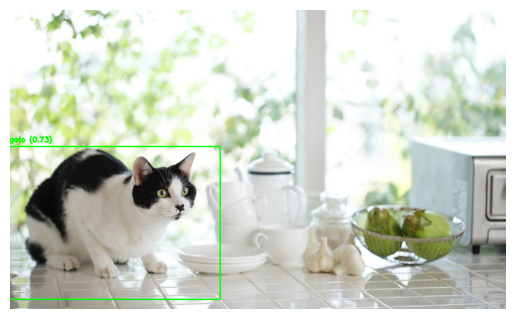

In [69]:
#prediccion con imagen:
import numpy as np
url = "/content/3-tips-para-mantener-a-tu-gato-lejos-de-la-encimera-3.jpg"


image=cv2.imread(url)
image= np.array(image)

regiones_propuestas = get_Region_Proposals(image, max_regiones=2000)

features = extract_features_from_regions(image, regiones_propuestas, vgg16)

predicted_labels = svm.predict(features)

probabilities = svm.predict_proba(features)

translations = regressor.predict(features)



selected_indices=[indice for indice in range(len(predicted_labels)) if(predicted_labels[indice] !=0 and predicted_labels[indice] != 'fondo')]

labels_filtered=[predicted_labels[i] for i in selected_indices]

print(labels_filtered)

boxes_filtered= [regiones_propuestas[i] for i in selected_indices]



scores_filtered=[probabilities[i] for i in selected_indices]

translations_filtered=[translations[i] for i in selected_indices]

bboxes_real_filtered=[calculate_inverse_translation(translations_filtered[i],boxes_filtered[i]) for i in range(len(selected_indices))]

bboxes_selected,scoress_selected=non_maximum_suppresssion (bboxes_real_filtered,scores_filtered,iou_threshold=0.3,prob_threshold=0.5)

clases=['gato','perro']
for pred_bbox,score in zip(bboxes_selected,scoress_selected):
  cv2.rectangle(image, (int(pred_bbox[0]), int(pred_bbox[1])), (int(pred_bbox[2]), int(pred_bbox[3])), (0, 255, 0), 2)
  cv2.putText(image, f'{clases[np.argmax(score)-1]} ({np.max(score):.2f})', (int(pred_bbox[0])+10,int(pred_bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 0), 2)



plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Desactivar los ejes para mostrar solo la imagen
plt.show()